# The Deep DRT: A Neural Network Approach to Deconvolve the Distribution of Relaxation Times (DRT)

## In this tutorial, we will reproduce the Figure 2 of the following article https://doi.org/10.1016/j.electacta.2021.139010.

In the deep-DRT model, we use a deep neural network (DNN) to deconvolve the DRT from EIS data. Leveraging this DNN, one can deconvolve the DRT, regress the impedance, and predict both at untested conditions by means of experimental states $\boldsymbol{\psi}$ , e.g. the temperature and the partial pressure of oxygen.

Given the experimental state $\boldsymbol{\psi} \in S_{\psi}$, we define $\boldsymbol{\gamma}( {\rm log} \boldsymbol{\tau}, \boldsymbol{\psi})=[\gamma ({\rm log}\tau_1, \boldsymbol{\psi}),\gamma ({\rm log}\tau_2, \boldsymbol{\psi}),...,\gamma ({\rm log}\tau_N, \boldsymbol{\psi})$]. 

The impedance $Z_{\rm DRT}(f,\psi)$ is expressed as


$$
Z_{\rm DRT}(f,\psi) = i2\pi L_0(\boldsymbol{\psi})+R_{\infty}\textbf{1}+\boldsymbol{A}\boldsymbol\gamma({\rm log}\boldsymbol{\tau},\boldsymbol{\psi})
$$


To deconvolve the DRT, the deep-DRT makes use of two feedforward networks: 1) an RL-network, whose parameters (i.e.
    biases and weights) are denoted as $\boldsymbol{\theta}_{\rm RL}$; and 2) a γ-network, whose parameters are denoted as $\boldsymbol{\theta}_{\gamma}$. 

This system of DNNs is trained by minimizing the following loss function $\mathcal{L}(\boldsymbol{\theta}_{\rm RL},\boldsymbol{\theta}_{\gamma})$:

$$
\\ \mathcal{L}(\boldsymbol{\theta}_{\rm RL},\boldsymbol{\theta}_{\gamma}) = \sum_{\boldsymbol{\psi}\in S_{\boldsymbol{\psi}}} \Vert \boldsymbol{Z}_{\mathrm{exp}} (\boldsymbol{f},\boldsymbol{\psi})-i2\pi L_{0,\rm DNN}(\boldsymbol{\psi},\boldsymbol{\theta}_{\rm RL}) \boldsymbol{f}-\mathit{R}_{\infty, \rm DNN}(\boldsymbol{\psi},\boldsymbol{\theta}_{\rm RL})\mathbf{1}- \boldsymbol{A}\boldsymbol{\gamma}_{\mathrm{DNN}}(\mathrm{log}\,\boldsymbol{\tau},\boldsymbol{\psi},\boldsymbol{\theta}_{\gamma})  \Vert^2_2
$$

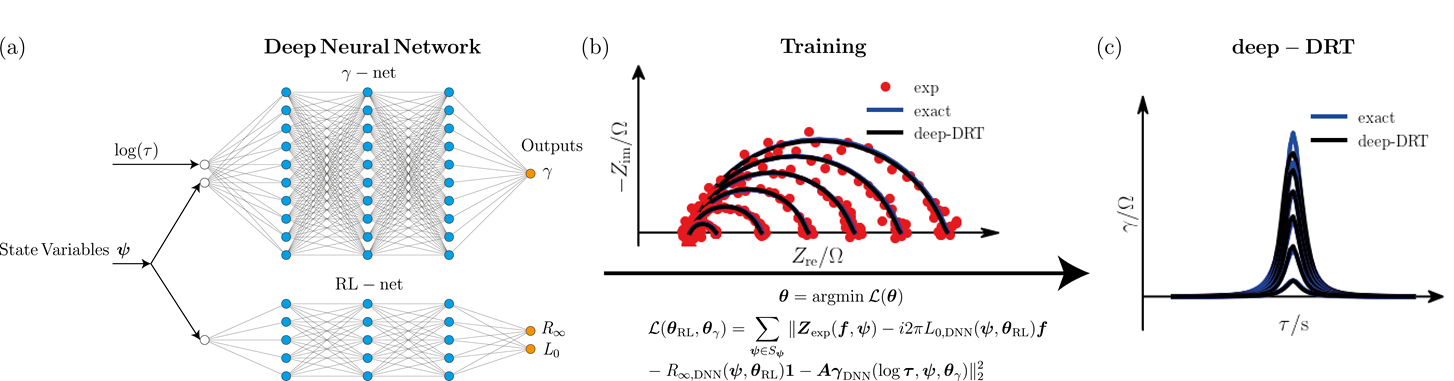

# Import the necessary modules

In [1]:
import os
import numpy as np
import compute_DRT
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from math import pi, sin, cos, sqrt
import importlib
importlib.reload(compute_DRT)

<module 'compute_DRT' from 'C:\\Users\\user\\AACODE\\DEEP_DRT\\deep-DRT\\tutorials\\compute_DRT.py'>

## 1) We define the parameters used for the 1xZARC model

The impedance of the 1xZARC model with the two-dimensional deep-DRT model, i.e., including one state variable $\psi$, is given by:

$$
Z_{ \rm exact}(f,\psi) = R_{\infty}+\displaystyle \frac{R_{\rm ct}(\psi)}{1+\left(i 2\pi f \tau _0(\psi)\right)^\phi}
$$

The corresponding analytical formula for the DRT is:

$$
\gamma(\log \tau, \psi) =  \displaystyle \frac{\displaystyle R_{\rm ct}(\psi)}{\displaystyle 2\pi} \displaystyle \frac{\displaystyle \sin\left((1-\phi)\pi\right)}{\displaystyle \cosh(\phi \log(\tau/\tau_0(\psi)))-\cos(\pi(1-\phi))}
$$

For the present case, we assume an affine dependency of $R_{\rm ct}$ with respect to $\psi$, i.e., $R_{\rm ct}(\psi) = R_{ct,0}+(R_{ct,1}-R_{ct,0})\psi$.

## 1.1) Frequencies and timescales range

In [2]:
# seed for reproducibility
torch.manual_seed(213912)

Tensor = torch.FloatTensor

# define frequency range
log_freq_min = -4.
log_freq_max = 4.
N_freqs = 10*int(log_freq_max-log_freq_min)+1
freq_vec = np.logspace(log_freq_min, log_freq_max, num=N_freqs, endpoint=True).reshape(N_freqs,1)

# define tau range
log_tau_min = -log_freq_max
log_tau_max = -log_freq_min
N_taus = 10*int(log_tau_max-log_tau_min)+1
tau_vec = np.logspace(log_tau_min, log_tau_max, num = N_taus, endpoint=True).reshape(N_taus,1)

# the ANN will take the normalized log10 of the tau vector as input
log_tau_vec = np.log(tau_vec)
log_tau_vec_norm = -1.+2.*(log_tau_vec-log_tau_vec.min())/(log_tau_vec.max()-log_tau_vec.min())

##  1.3) Single ZARC model

In [4]:
# data for the exact impedance
R_inf = 10.
R_ct_0 = 50.
phi = 0.8
sigma_n_exp_0 = 1. 
tau_0 = 1.

## 2) Artificial experiments generation and DNN input 

In [5]:
# declare lists that store:
# 1) data
freq_vec_list = []
Z_re_list = []
Z_im_list = []
gamma_exact_list = []
Z_re_exact_list = []
Z_im_exact_list = []

# 2) DRT-to-impedance and derivative matrices
A_re_list = []
A_im_list = []
L_list = []

# 3) indices for unpacking
index_unpack_list = []

# this is for the NN input
input_R_inf_NN = np.array([], dtype=np.int64).reshape(0,1) # only T for now
input_x_NN = np.array([], dtype=np.int64).reshape(0,2) # no zeta for now

# experimental parameters
# we assume one parameter is the "temperature"
# which varies from 0 to 1
T_min = 0.
T_max = 1.
N_exp = 11
delta_T = (T_max-T_min)/(N_exp-1)
scaling_vec = np.linspace(1. , 0.1, num=N_exp, endpoint=True)
T_range = np.arange(T_min, T_max+delta_T, delta_T)

for index, T_loc in enumerate(T_range):

    # impedance
    R_ct = R_ct_0*scaling_vec[index]
    T_0 = tau_0**phi/R_ct
    Z_exact = R_inf + 1./(1./R_ct+T_0*(1j*2.*pi*freq_vec)**phi)
    gamma_exact = (R_ct)/(2.*pi)*sin((1.-phi)*pi)/(np.cosh(phi*np.log(tau_vec/tau_0))-cos((1.-phi)*pi))
    sigma_n_exp = sigma_n_exp_0*sqrt(scaling_vec[index])
    Z_exp = Z_exact + (sigma_n_exp**2)*np.random.normal(0, 1, Z_exact.shape) + 1j*(sigma_n_exp**2)*np.random.normal(0, 1, Z_exact.shape)

    # 1) data:
    # 1.a) to numpy
    # freq_vec is the same for all
    Z_re = np.real(Z_exp)
    Z_im = np.imag(Z_exp)

    # 1.b) to torch
    freq_vec_torch = torch.from_numpy(freq_vec).type(Tensor)
    Z_re_torch = torch.from_numpy(Z_re).type(Tensor)
    Z_im_torch = torch.from_numpy(Z_im).type(Tensor)

    # 1.c) in list storage
    freq_vec_list.append(freq_vec_torch.detach())
    Z_re_list.append(Z_re_torch.detach())
    Z_im_list.append(Z_im_torch.detach())
    
    gamma_exact_list.append(gamma_exact)
    Z_re_exact_list.append(Z_exact.real)
    Z_im_exact_list.append(Z_exact.imag)    

    # 2.a) build the matrices
    # 2.a.1) decide the discretization
    rbf_type =  'pwl' #'gaussian' # 
    epsilon = 0.0 # compute_DRT.compute_epsilon(tau_vec, rbf_type) #  
    
    # 2.a.2) compute the matrices
    A_re = compute_DRT.A_re(freq_vec, tau_vec, epsilon, rbf_type)
    A_im = compute_DRT.A_im(freq_vec, tau_vec, epsilon, rbf_type)
    L = compute_DRT.L(tau_vec)

    # 2.b) transform the np matrices to torch
    A_re_torch = torch.from_numpy(A_re).type(Tensor)
    A_im_torch = torch.from_numpy(A_im).type(Tensor)
    L_torch = torch.from_numpy(L).type(Tensor)

    # 2.c) put the torch matrices in storage
    A_re_list.append(A_re_torch.detach())
    A_im_list.append(A_im_torch.detach())
    L_list.append(L_torch.detach())
    
    # 3) set up the neural network inputs
    # note that the network input is a pytorch tensor
    # and not a list as the A and L above
    # 3.a) needed "temperature"
    # 3.b) input for the network that outputs RL
    input_R_inf_NN = np.vstack((input_R_inf_NN, T_loc))

    # 3.c) input for the gamma network
    T_loc_vec = T_loc*np.ones_like(log_tau_vec_norm)
    input_loc = np.hstack((T_loc_vec, log_tau_vec_norm))
    input_x_NN = np.vstack((input_x_NN, input_loc))

    # 4) store indices for unpacking
    index_unpack_end = input_x_NN.shape[0]
    index_unpack_start = index_unpack_end-N_taus    
    index_unpack_list.append((index_unpack_start, index_unpack_end))

    # data used in NN is transform to a pytorch tensor
    input_R_inf_NN_torch = torch.from_numpy(input_R_inf_NN).type(Tensor)
    input_x_NN_torch = torch.from_numpy(input_x_NN).type(Tensor)
    


## 2.1) The DNN system

### 2.1) we define the DNN parameters

In [25]:
# define the neural network
# D_in is input dimension;
# H is hidden dimension
# D_out is output dimension.

D_in_x = 2 # this is the tau + "temperature"
D_in_R_inf = 1 # this is the "temperature" only
H_x = 50
H_R_inf = 10
D_out_x = 1
D_out_R_inf = 1

# Define model
class x_NN(torch.nn.Module):
    def __init__(self):
        
        super(x_NN, self).__init__()
        self.fct_1 = torch.nn.Linear(D_in_x, H_x)
        self.fct_2 = torch.nn.Linear(H_x, H_x)
        self.fct_3 = torch.nn.Linear(H_x, H_x)
        self.fct_4 = torch.nn.Linear(H_x, H_x)
        self.fct_5 = torch.nn.Linear(H_x, H_x)
        self.fct_6 = torch.nn.Linear(H_x, H_x)
        self.fct_7 = torch.nn.Linear(H_x, H_x)
        self.fct_8 = torch.nn.Linear(H_x, D_out_x)

        torch.nn.init.xavier_normal_(self.fct_1.weight)
        torch.nn.init.xavier_normal_(self.fct_2.weight)
        torch.nn.init.xavier_normal_(self.fct_3.weight)
        torch.nn.init.xavier_normal_(self.fct_4.weight)
        torch.nn.init.xavier_normal_(self.fct_5.weight)
        torch.nn.init.xavier_normal_(self.fct_6.weight)
        torch.nn.init.xavier_normal_(self.fct_7.weight)
        torch.nn.init.xavier_normal_(self.fct_8.weight)

        torch.nn.init.zeros_(self.fct_1.bias)
        torch.nn.init.zeros_(self.fct_2.bias)
        torch.nn.init.zeros_(self.fct_3.bias)
        torch.nn.init.zeros_(self.fct_4.bias)
        torch.nn.init.zeros_(self.fct_5.bias)
        torch.nn.init.zeros_(self.fct_6.bias)
        torch.nn.init.zeros_(self.fct_7.bias)
        torch.nn.init.zeros_(self.fct_8.bias)

    def forward(self, freq):

        h = F.elu(self.fct_1(freq))
        h = F.elu(self.fct_2(h))
        h = F.elu(self.fct_3(h))
        h = F.elu(self.fct_4(h))
        h = F.elu(self.fct_5(h))
        h = F.elu(self.fct_6(h))
        h = F.elu(self.fct_7(h))
        gamma = F.softplus(self.fct_8(h))        
        
        return gamma
    
# Define model
class R_inf_NN(torch.nn.Module):
    def __init__(self):
        
        super(R_inf_NN, self).__init__()
        self.fct_1 = torch.nn.Linear(D_in_R_inf, H_R_inf)
        self.fct_2 = torch.nn.Linear(H_R_inf, H_R_inf)
        self.fct_3 = torch.nn.Linear(H_R_inf, H_R_inf)
        self.fct_4 = torch.nn.Linear(H_R_inf, H_R_inf)
        self.fct_5 = torch.nn.Linear(H_R_inf, H_R_inf)
        self.fct_6 = torch.nn.Linear(H_R_inf, H_R_inf)
        self.fct_7 = torch.nn.Linear(H_R_inf, H_R_inf)
        self.fct_8 = torch.nn.Linear(H_R_inf, D_out_R_inf)

        torch.nn.init.xavier_normal_(self.fct_1.weight)
        torch.nn.init.xavier_normal_(self.fct_2.weight)
        torch.nn.init.xavier_normal_(self.fct_3.weight)
        torch.nn.init.xavier_normal_(self.fct_4.weight)
        torch.nn.init.xavier_normal_(self.fct_5.weight)
        torch.nn.init.xavier_normal_(self.fct_6.weight)
        torch.nn.init.xavier_normal_(self.fct_7.weight)
        torch.nn.init.xavier_normal_(self.fct_8.weight)

        torch.nn.init.zeros_(self.fct_1.bias)
        torch.nn.init.zeros_(self.fct_2.bias)
        torch.nn.init.zeros_(self.fct_3.bias)
        torch.nn.init.zeros_(self.fct_4.bias)
        torch.nn.init.zeros_(self.fct_5.bias)
        torch.nn.init.zeros_(self.fct_6.bias)
        torch.nn.init.zeros_(self.fct_7.bias)
        torch.nn.init.zeros_(self.fct_8.bias)

    def forward(self, freq):

        h = F.elu(self.fct_1(freq))
        h = F.elu(self.fct_2(h))
        h = F.elu(self.fct_3(h))
        h = F.elu(self.fct_4(h))
        h = F.elu(self.fct_5(h))
        h = F.elu(self.fct_6(h))
        h = F.elu(self.fct_7(h))
        gamma = F.softplus(self.fct_8(h))        
        
        return gamma

model_x = x_NN()
model_R_inf = R_inf_NN()

### 2.2) Loss function $\mathcal{L}(\boldsymbol{\theta}_{\rm RL},\boldsymbol{\theta}_{\gamma})$ used to train the DNN system 

We use ridge regression and set the penalty coefficient to zero.

In [6]:
def loss_fn(R_inf_NN_output, x_NN_output, freq_vec_list, Z_re_list, Z_im_list, A_re_list, A_im_list, index_unpack_list):
    
    MSE = 0
    for index in range(0, len(freq_vec_list)):
        
        # unpack the neural network input
        R_inf = R_inf_NN_output[index, 0]
        
        # unpack gamma
        index_unpack = range(index_unpack_list[index][0], index_unpack_list[index][1])
        x = x_NN_output[index_unpack,0].reshape(N_taus,1)

        # external data
        Z_re = Z_re_list[index]
        Z_im = Z_im_list[index]
        
        # A matrices
        A_re = A_re_list[index]
        A_im = A_im_list[index]
        
        MSE_re = torch.sum((R_inf + torch.matmul(A_re,x) - Z_re)**2)
        MSE_im = torch.sum((torch.matmul(A_im,x) - Z_im)**2)
        MSE = MSE + MSE_re + MSE_im
    
    return MSE

## 3) Training the DNN system to deconvolve DRT from EIS data

#### To train the parameters of the DNNs (i.e. weights and biases), we set the learning rate and used ADAM as optimizer to minimize the loss function $\mathcal{L}(\boldsymbol{\theta}_{\rm RL},\boldsymbol{\theta}_{\gamma})$.

In [27]:
# optimize the neural network
loss_vec = np.array([])

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which tensors it should update.

learning_rate = 1e-4
optimizer = torch.optim.Adam(model_x.parameters(), lr=learning_rate)#, weight_decay=1E-4)
optimizer.add_param_group({"params": model_R_inf.parameters()})

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.8)
max_iters = 30001
 
x_NN_store = torch.zeros((max_iters, N_taus, N_exp)).type(Tensor)
R_inf_NN_store = torch.zeros((max_iters, N_exp)).type(Tensor)

loss_old = 0


for t in range(max_iters):
    # Forward pass: compute predicted y by passing x to the model.
    R_inf_NN_output = model_R_inf(input_R_inf_NN_torch)
    x_NN_output = model_x(input_x_NN_torch)
    
    # Compute the loss
    loss = loss_fn(R_inf_NN_output, x_NN_output, 
                    freq_vec_list, Z_re_list, Z_im_list,
                    A_re_list, A_im_list, index_unpack_list)
    
    loss_new = loss.item()
    loss_old = loss_new
    
    # save it
    loss_vec = np.append(loss_vec, loss.item())
    
    # store gamma
    x_NN_store[t, :] = x_NN_output.detach().reshape(N_exp, N_taus).T
    
    # store R_inf
    R_inf_NN_store[t, :] = R_inf_NN_output[:,0].detach()

    # and print it
    if not t%200:
        print('iter=%d; loss=%e' % (t, loss.item()))

    # Before starting the optimizer we can note that the learning rate
    # can be modified on the go, see
    # https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
    # It would be nice to implement this option in the future.
    
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

iter=0; loss=3.941009e+05
iter=200; loss=7.396623e+04
iter=400; loss=3.853563e+04
iter=600; loss=3.375848e+04
iter=800; loss=2.014846e+04
iter=1000; loss=5.641919e+03
iter=1200; loss=2.561314e+03
iter=1400; loss=1.823672e+03
iter=1600; loss=1.503573e+03
iter=1800; loss=1.321933e+03
iter=2000; loss=1.202834e+03
iter=2200; loss=1.117909e+03
iter=2400; loss=1.054056e+03
iter=2600; loss=1.004215e+03
iter=2800; loss=9.641944e+02
iter=3000; loss=9.313564e+02
iter=3200; loss=9.039942e+02
iter=3400; loss=8.810214e+02
iter=3600; loss=8.618273e+02
iter=3800; loss=8.461813e+02
iter=4000; loss=8.340659e+02
iter=4200; loss=8.253203e+02
iter=4400; loss=8.192715e+02
iter=4600; loss=8.147895e+02
iter=4800; loss=8.107779e+02
iter=5000; loss=8.065779e+02
iter=5200; loss=8.018835e+02
iter=5400; loss=7.964928e+02
iter=5600; loss=7.902430e+02
iter=5800; loss=7.828630e+02
iter=6000; loss=7.741253e+02
iter=6200; loss=7.638217e+02
iter=6400; loss=7.516828e+02
iter=6600; loss=7.382901e+02
iter=6800; loss=7.248

## 3.1) Plot of impedance recovery

### Figure (2a) in deep-DRT paper

In [43]:
# first step is look at the distance
distance_vec = np.zeros(len(x_NN_store))

for iter_pt in range(len(x_NN_store)):
    distance_loc = 0.

    for index in range(len(T_range)):
        # collect the gamma from the results
        x = x_NN_store[iter_pt, :, index]
        gamma = np.squeeze(x)

        # get the exact gamma
        x = gamma_exact_list[index]
        gamma_exact = np.squeeze(x)

        distance_loc += np.linalg.norm(gamma-gamma_exact)

    distance_vec[iter_pt] = distance_loc

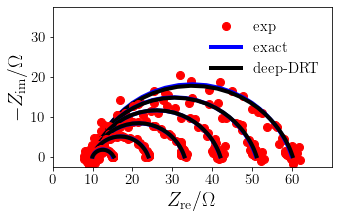

In [44]:
iter_opt = np.argmin(distance_vec)

for index in range(len(T_range)):
    
    if (index+1)%2:
        temp = T_range[index]
        # experimental data
        Z_re_exp = Z_re_list[index]
        Z_im_exp = Z_im_list[index]
        
        # A matrices
        A_re = A_re_list[index]
        A_im = A_im_list[index]
        
        # stored values
        x = x_NN_store[iter_opt, :, index].reshape(N_taus,1)
        R_inf = R_inf_NN_store[iter_opt, index]
    
        # model results
        Z_re_model = R_inf + np.matmul(A_re,x)
        Z_im_model = np.matmul(A_im,x)
      
        if index == 0:
            label_exp = "exp"
            label_exact = 'exact'
            label_DRT = "deep-DRT"
        else:
            label_exp = ''
            label_exact = ''
            label_DRT = ''         
            
        plt.plot(Z_re_exp, -Z_im_exp, "o", markersize=8, color="red", label=label_exp)
        plt.plot(Z_re_exact_list[index], -Z_im_exact_list[index], linewidth=4, color="blue", label=label_exact)
        plt.plot(Z_re_model, -Z_im_model, linewidth=4, color="black", label=label_DRT)

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.legend(frameon=False, fontsize = 15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
# plt.axis([0,70,-2.5,32.5])
plt.axis([0,70,-2.5,37.5])
plt.xticks(np.arange(0, 70, step=10))
plt.legend(frameon=False, fontsize = 15)
plt.gca().set_aspect('equal', adjustable='box')
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
fig = plt.gcf()
fig.set_size_inches(5, 4)
plt.show()


## 3.2) Plot of recovered DRT
### Figure 2(b) in deep-DRT paper  

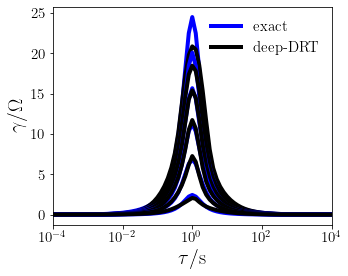

In [45]:
for index in range(len(T_range)):
    
    if (index+1)%2:
        # stored values
        x = x_NN_store[iter_opt, :, index].reshape(N_taus,1)
        gamma = x
        gamma_exact  = gamma_exact_list[index]
        
        if index == 0:
            label_exact = 'exact'
            label_DRT = "deep-DRT"
        else:
            label_exact = ''
            label_DRT = ''      
            
        plt.semilogx(tau_vec, gamma_exact, linewidth=4, color="blue", label=label_exact)
        plt.semilogx(tau_vec, gamma, linewidth=4, color="black", label=label_DRT)
  
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.xlim(1E-4, 1E4)
# plt.ylim(-10, 40)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.legend(frameon=False, fontsize = 15)
plt.xlabel(r'$\tau/\rm s$', fontsize=20)
plt.ylabel(r'$\gamma/\Omega$', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(5, 4)
plt.show()